In [1]:
import tensorflow as tf
import os
tf.__version__

'2.8.0'

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
file_path='/content/drive/MyDrive/dt_2'
train_path='/content/drive/MyDrive/dt_2/train'
train_normal_path='/content/drive/MyDrive/dt_2/train/Normal'
train_osteoporosis_path='/content/drive/MyDrive/dt_2/train/Osteoporosis'
validation_path='/content/drive/MyDrive/dt_2/val'
validation_normal_path='/content/drive/MyDrive/dt_2/val/Normal'
validation_osteoporosis_path='/content/drive/MyDrive/dt_2/val/Osteoporosis'
test_path='/content/drive/MyDrive/dt_2/test'
test_normal_path='/content/drive/MyDrive/dt_2/test/Normal'
test_osteoporosis_path='/content/drive/MyDrive/dt_2/test/Osteoporosis'

In [4]:
import pathlib
import numpy as np
data_dir=pathlib.Path(train_path)
class_names=np.array([item.name for item in data_dir.glob('*')])
print(class_names)

['Normal' 'Osteoporosis']


In [5]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
tf.random.set_seed(42)
# Preprocess data (get all of the pixel values between 1 and 0, also called scaling/normalization)
train_datagen = ImageDataGenerator(rescale=1/255.,
                                             rotation_range=20, 
                                             shear_range=0.2, 
                                             zoom_range=0.2,
                                             width_shift_range=0.2,
                                             height_shift_range=0.2,
                                             horizontal_flip=True) 
valid_datagen = ImageDataGenerator(rescale=1/255.)

train_data = train_datagen.flow_from_directory(train_path,
                                               batch_size=32,
                                               color_mode='grayscale',
                                               target_size=(224, 224),
                                               class_mode="binary", 
                                               seed=42,
                                               )

valid_data = valid_datagen.flow_from_directory(validation_path,
                                               batch_size=32,
                                               color_mode='grayscale',
                                               target_size=(224, 224),
                                               class_mode="binary",
                                               seed=42,
                                               
                                               )

Found 1365 images belonging to 2 classes.
Found 390 images belonging to 2 classes.


In [6]:
test_datagen=ImageDataGenerator(rescale=1/255.)
test_data=test_datagen.flow_from_directory(test_path,
                                               batch_size=16,
                                               color_mode='grayscale',
                                               target_size=(224, 224),
                                               class_mode="binary",
                                               seed=42,
                                           shuffle=False,
                                           
                                               )

Found 197 images belonging to 2 classes.


In [7]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense, Flatten, Activation,Input,GlobalAveragePooling2D,Dropout
from tensorflow.keras import Sequential
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.models import Model

In [8]:
IMAGE_SIZE = [224, 224,3]
vgg_model = VGG16(input_shape=IMAGE_SIZE,include_top=False, weights='imagenet')
print(vgg_model.summary())

58900480/58889256 [==============================] - 0s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                              

In [9]:
IMAGE_SIZE = [224, 224,1]
vgg_model = VGG16(input_shape=IMAGE_SIZE,include_top=False, weights='imagenet')
print(vgg_model.summary())

ValueError: ignored

In [ ]:
vgg_config = vgg_model.get_config()

In [ ]:
h, w, c = 224, 224, 1
vgg_config["layers"][0]["config"]["batch_input_shape"] = (None, h, w, c)

In [ ]:
vgg_updated = Model.from_config(vgg_config)
print(vgg_updated.summary())

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 1)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      640       
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [ ]:
orig_model_conv1_block1_wts = vgg_model.layers[1].get_weights()[0]

print(orig_model_conv1_block1_wts[:,:,0,0])
print(orig_model_conv1_block1_wts[:,:,1,0])
print(orig_model_conv1_block1_wts[:,:,2,0])

[[ 0.42947057  0.373467   -0.06136011]
 [ 0.27476987  0.03868078 -0.36722335]
 [-0.05746817 -0.26224968 -0.35009676]]
[[ 0.55037946  0.44007453 -0.08138704]
 [ 0.34573907  0.04063221 -0.4535013 ]
 [-0.05863491 -0.33066967 -0.4850302 ]]
[[ 0.4800154   0.4085474  -0.06514555]
 [ 0.31047726  0.05020237 -0.40338343]
 [-0.05087169 -0.2852275  -0.41851634]]


In [ ]:
new_model_conv1_block1_wts = vgg_updated.layers[1].get_weights()[0]
print(new_model_conv1_block1_wts[:,:,0,0])

[[ 0.019847    0.06881626  0.01473777]
 [-0.02527809 -0.0296221  -0.01002889]
 [-0.07189301 -0.09086246  0.01742476]]


In [ ]:
def avg_wts(weights):  
  average_weights = np.mean(weights, axis=-2).reshape(weights[:,:,-1:,:].shape)  
  return(average_weights)

In [ ]:
vgg_updated_config = vgg_updated.get_config()
vgg_updated_layer_names = [vgg_updated_config['layers'][x]['name'] for x in range(len(vgg_updated_config['layers']))]
first_conv_name = vgg_updated_layer_names[1]

In [ ]:
for layer in vgg_model.layers:
    if layer.name in vgg_updated_layer_names:
     
      if layer.get_weights() != []:
        target_layer = vgg_updated.get_layer(layer.name)
    
        if layer.name in first_conv_name: 
          weights = layer.get_weights()[0]
          biases  = layer.get_weights()[1]
          
          weights_single_channel = avg_wts(weights)
                                                    
          target_layer.set_weights([weights_single_channel, biases]) 
          target_layer.trainable = False  
    
        else:
          target_layer.set_weights(layer.get_weights())    
          target_layer.trainable = False  

In [ ]:
new_model_conv1_block1_wts_updated = vgg_updated.layers[1].get_weights()[0]
print(new_model_conv1_block1_wts_updated[:,:,0,0])

[[ 0.48662183  0.40736297 -0.06929757]
 [ 0.31032872  0.04317178 -0.40803602]
 [-0.05565825 -0.29271564 -0.4178811 ]]


In [ ]:
model_1 = Sequential()
model_1.add(vgg_updated)
model_1.add(Flatten())
model_1.add(Dense(activation = 'relu', units = 32))
model_1.add(Dense(activation = 'relu', units = 32))
model_1.add(Dense(activation = 'sigmoid', units = 1))

In [ ]:
model_1.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14713536  
                                                                 
 flatten_2 (Flatten)         (None, 25088)             0         
                                                                 
 dense_13 (Dense)            (None, 32)                802848    
                                                                 
 dense_14 (Dense)            (None, 32)                1056      
                                                                 
 dense_15 (Dense)            (None, 1)                 33        
                                                                 
Total params: 15,517,473
Trainable params: 803,937
Non-trainable params: 14,713,536
_________________________________________________________________


In [ ]:
model_1.compile(loss="binary_crossentropy",
              optimizer=Adam(),
              metrics=["accuracy"])

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping,ReduceLROnPlateau
early = EarlyStopping(monitor="val_loss", mode="min", patience=4)
learning_rate_reduction = ReduceLROnPlateau(monitor="val_loss", patience = 2, verbose=1,factor=0.3, min_lr=0.000001)
callbacks_list = [ early, learning_rate_reduction]

In [ ]:
from sklearn.utils import class_weight
from sklearn.utils.class_weight import compute_class_weight
weights = compute_class_weight(
    class_weight='balanced', 
    classes=np.unique(train_data.classes), 
    y=train_data.classes)
cw = dict(zip( np.unique(train_data.classes), weights))
print(cw)

{0: 0.9112149532710281, 1: 1.1079545454545454}


In [ ]:
history_1=model_1.fit(train_data,
                      epochs=25,
                      steps_per_epoch=len(train_data),
                      validation_data=valid_data,
                      validation_steps=len(valid_data),
                      callbacks=callbacks_list,
                      class_weight=cw)

Epoch 1/25
43/43 [==============================] - 19s 418ms/step - loss: 0.7017 - accuracy: 0.5590 - val_loss: 0.6590 - val_accuracy: 0.5974 - lr: 0.0010
Epoch 2/25
43/43 [==============================] - 18s 408ms/step - loss: 0.5641 - accuracy: 0.6996 - val_loss: 0.5078 - val_accuracy: 0.7718 - lr: 0.0010
Epoch 3/25
43/43 [==============================] - 18s 411ms/step - loss: 0.4728 - accuracy: 0.7795 - val_loss: 0.4043 - val_accuracy: 0.8410 - lr: 0.0010
Epoch 4/25
43/43 [==============================] - 18s 409ms/step - loss: 0.4854 - accuracy: 0.7641 - val_loss: 0.5520 - val_accuracy: 0.7308 - lr: 0.0010
Epoch 5/25
43/43 [==============================] - ETA: 0s - loss: 0.4488 - accuracy: 0.7941
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
43/43 [==============================] - 18s 421ms/step - loss: 0.4488 - accuracy: 0.7941 - val_loss: 0.5868 - val_accuracy: 0.6718 - lr: 0.0010
Epoch 6/25
43/43 [==============================] - 18s 409ms

In [ ]:
model_1.evaluate(test_data)

13/13 [==============================] - 21s 2s/step - loss: 0.1693 - accuracy: 0.9289


[0.16926614940166473, 0.9289340376853943]

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
def plot_loss_curves(history):
 
  loss = history.history['loss']
  val_loss = history.history['val_loss']
  epochs = range(len(history.history['loss']))

  plt.figure()
  plt.plot(epochs, loss, label='training_loss')
  plt.plot(epochs, val_loss, label='val_loss')
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.legend();

  

In [ ]:
def plot_accuracy_curves(history):
  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  epochs = range(len(history.history['loss']))
  plt.figure()
  plt.plot(epochs, accuracy, label='training_accuracy')
  plt.plot(epochs, val_accuracy, label='val_accuracy')
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.legend();

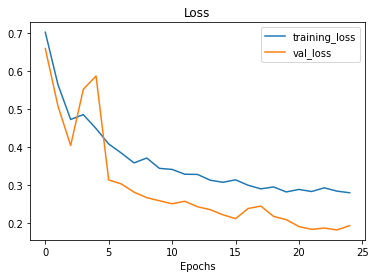

In [ ]:
plot_loss_curves(history_1)

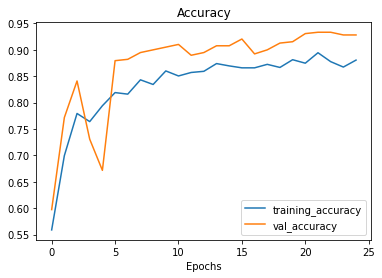

In [ ]:
plot_accuracy_curves(history_1)

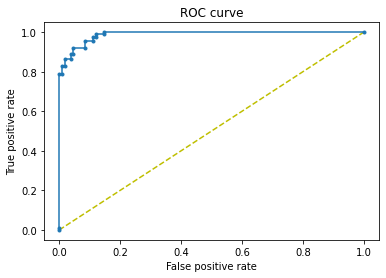

In [ ]:
y_test=test_data.classes
from sklearn.metrics import roc_curve
y_preds = model_1.predict(test_data).ravel()

fpr, tpr, thresholds = roc_curve(y_test, y_preds)
plt.figure(1)
plt.plot([0, 1], [0, 1], 'y--')
plt.plot(fpr, tpr, marker='.')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.show()

In [ ]:
import pandas as pd
i = np.arange(len(tpr)) 
roc = pd.DataFrame({'tf' : pd.Series(tpr-(1-fpr), index=i), 'thresholds' : pd.Series(thresholds, index=i)})
ideal_roc_thresh = roc.iloc[(roc.tf-0).abs().argsort()[:1]] 
print("Ideal threshold is: ", ideal_roc_thresh['thresholds']) 

Ideal threshold is:  11    0.58845
Name: thresholds, dtype: float32


In [ ]:
from sklearn.metrics import auc
auc_value = auc(fpr, tpr)
print("Area under curve, AUC = ", auc_value)

Area under curve, AUC =  0.9882438618393674


In [ ]:
preds = model_1.predict(test_data,verbose=1)

13/13 [==============================] - 2s 153ms/step


In [ ]:
predictions = preds.copy()
predictions[predictions <= 0.58] = 0
predictions[predictions > 0.58] = 1

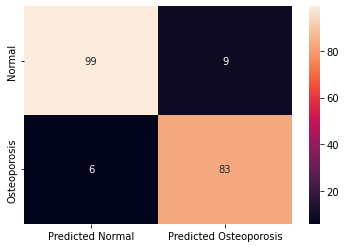

In [ ]:
from sklearn.metrics import classification_report,confusion_matrix
cm = pd.DataFrame(data=confusion_matrix(test_data.classes, predictions, labels=[0, 1]),index=[ "Normal", "Osteoporosis"],

)
import seaborn as sns
sns.heatmap(cm,annot=True,fmt="d")

In [ ]:
print(classification_report(y_true=test_data.classes,y_pred=predictions,target_names =['NORMAL','Osteoporosis']))

              precision    recall  f1-score   support

      NORMAL       0.94      0.92      0.93       108
Osteoporosis       0.90      0.93      0.92        89

    accuracy                           0.92       197
   macro avg       0.92      0.92      0.92       197
weighted avg       0.92      0.92      0.92       197



In [ ]:
model_1.save("vgg16_model.h5")